# Dependencies

In [1]:
!pip install seaborn matplotlib pandas numpy

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json

# Experiment 1: The Effect of Train Size MSA

In [3]:
root = "results/ex_trainsize/"

data = {}
for f in os.listdir(root):
    if not f.endswith(".json"):
        continue
    name = f.split("results_common_voice_")[1].split(".json")[0]
    with open(os.path.join(root, f), "r") as file:
        data[name] = json.load(file)
df_trainsize = pd.DataFrame(data).drop(["eval_samples_per_second", "eval_steps_per_second", "eval_runtime", "eval_loss"])
keys = ["whisper-tiny", "whisper-base", "whisper-small", "whisper-medium", "0.2", "0.4", "0.6", "0.8", "1.0", "whisper-large-v3"]
for t_size in keys:
    mean = df_trainsize[[f"{t_size}_seed42", f"{t_size}_seed84", f"{t_size}_seed168"]].mean(axis=1)
    std = df_trainsize[[f"{t_size}_seed42", f"{t_size}_seed84", f"{t_size}_seed168"]].std(axis=1)
    df_trainsize[t_size] = [f"{m:.2f} ± {s:.2f}" for m, s in zip(mean, std)]

# merge into mean +- std
df_trainsize.drop(["0.2_seed42","0.2_seed84","0.2_seed168"], axis=1, inplace=True)
df_trainsize = df_trainsize[keys].T
df_trainsize.rename(index={"whisper-small": "whisper\nsmall (0%)", "0.2": "20%", "0.4": "40%", "0.6": "60%", "0.8": "80%", "1.0": "100%", "whisper-base": "whisper\nbase", "whisper-tiny": "whisper\ntiny", "whisper-medium": "whisper\nmedium", "whisper-large-v3": "whisper\nlarge-v3"}, inplace=True)
df_trainsize.rename(columns={"eval_wer": "WER", "eval_cer": "CER"}, inplace=True)
df_trainsize

,WER,CER
whisper\ntiny,101.05 ± 0.28,54.56 ± 0.21
whisper\nbase,95.92 ± 1.26,49.97 ± 1.00
whisper\nsmall (0%),61.93 ± 0.39,26.83 ± 0.29
whisper\nmedium,52.84 ± 0.25,22.25 ± 0.24
20%,51.66 ± 0.10,22.72 ± 0.15
40%,49.68 ± 0.37,22.09 ± 0.42
60%,48.50 ± 0.15,21.50 ± 0.19
80%,47.12 ± 0.22,20.68 ± 0.15
100%,45.93 ± 0.12,20.11 ± 0.10
whisper\nlarge-v3,43.20 ± 0.16,16.90 ± 0.10


/var/folders/n5/h56c44710msgjz3ldp1zl6vw0000gn/T/ipykernel_41688/2185728440.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  means = df_trainsize.applymap(lambda x: float(x.split(" ± ")[0]))
/var/folders/n5/h56c44710msgjz3ldp1zl6vw0000gn/T/ipykernel_41688/2185728440.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stds = df_trainsize.applymap(lambda x: float(x.split(" ± ")[1]))


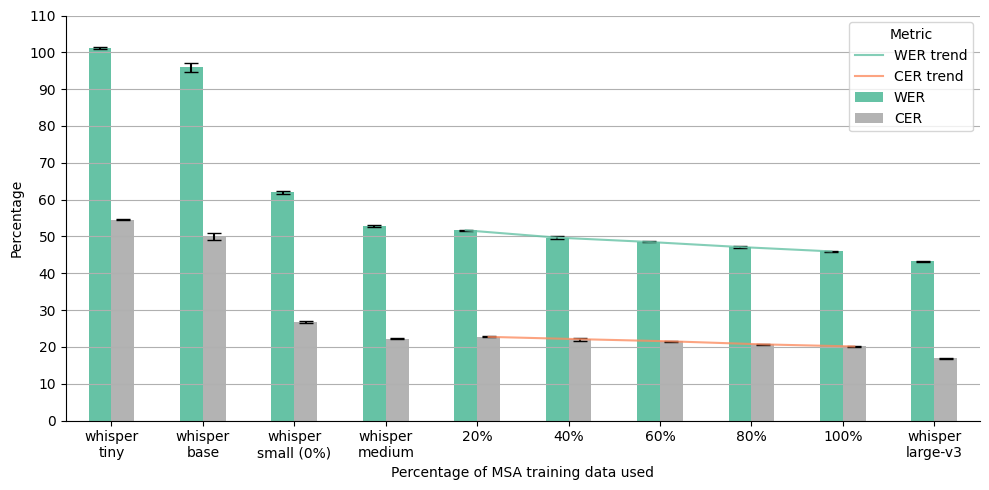

In [4]:
# plot the data in a bar plot with each row as a separate bar
means = df_trainsize.applymap(lambda x: float(x.split(" ± ")[0]))
stds = df_trainsize.applymap(lambda x: float(x.split(" ± ")[1]))

fig, ax = plt.subplots(figsize=(10, 5))
# means.plot(kind='bar', yerr=stds, ax=ax, rot=0, colormap='Set2', capsize=5, stacked=True)
means.plot(kind='bar', yerr=stds, ax=ax, rot=0, colormap='Set2', capsize=5, stacked=False, legend=False)
# set colors
colors = sns.color_palette("Set2", len(means.columns))
for i, col in enumerate(means.columns):
    offset = 0.125 - (0.25 * i)
    ax.plot(np.arange(4 - offset, len(means)-1-offset), means[col].values[4:-1], marker='', linestyle='-', label=f'{col} trend', alpha=0.8, color=colors[i])

# plt.title("Model performance on MSA dataset with different training sizes", fontweight='bold')
sns.despine()
plt.ylabel("Percentage")
plt.xlabel("Percentage of MSA training data used")
plt.legend(title="Metric")
plt.grid(axis='y')
plt.yticks(np.arange(0, 111, 10))
plt.tight_layout()
plt.savefig("results/plots/ex_trainsize.pdf")
plt.show()

# Experiment 2: Comparison with and without pre-training

In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json

def load_results(root, prefix, format=True):
    data = {}
    dfs = []
    files = os.listdir(root)
    files.sort()
    for f in files:
        if not f.endswith(".json"):
            continue
        name = f.split(f"results_whisper-small-{prefix}_")[1].split(".json")[0]
        with open(os.path.join(root, f), "r") as file:
            data[name] = json.load(file)
        df = pd.DataFrame(data[name]).drop(["eval_samples_per_second", "eval_steps_per_second", "eval_runtime", "eval_loss"])
        df["model"] = name.title()
        df.columns = df.columns.str.title()
        df.rename(columns={"Msa": "MSA"}, inplace=True)
        dfs.append(df)
        
    df = pd.concat(dfs).T
    df.columns = pd.MultiIndex.from_tuples([tuple(c.split("_")) for c in df.columns])
    df.columns = df.columns.droplevel(0)
    df.columns = pd.MultiIndex.from_tuples([(df.iloc[-1].iloc[i], c) for i, c in enumerate(df.columns)], names=["model", "metric"])
    df = df.drop(df.index[-1])
    df = df.T
    df_wer = df.xs("wer", level="metric")
    df_cer = df.xs("cer", level="metric")
    df = pd.concat([df_wer, df_cer], keys=["WER", "CER"], names=["metric"])
    df = df.astype(float).round(2)
    df = df.reindex([("WER", k) for k in list(df.index.levels[1])] + [("CER", k) for k in list(df.index.levels[1])])
    # Extract base dialect from model names (e.g., "Egyptian" from "Egyptian168")
    base_dialects = df.index.get_level_values('model').str.extract(r'^([A-Za-z]+)', expand=False)

    # Create groupers combining metric and base dialect
    groupers = [df.index.get_level_values('metric'), base_dialects]

    # Group and calculate statistics
    grouped = df.groupby(groupers).agg(['mean', 'std'])

    if format:
        # Format results as "mean ± std" strings
        formatted_data = {}
        for dialect in df.columns:
            mean = grouped[(dialect, 'mean')]
            std = grouped[(dialect, 'std')]
            formatted_data[dialect] = [f"{m:.2f} ± {s:.2f}" for m, s in zip(mean, std)]

        # Create final DataFrame
        df = pd.DataFrame(formatted_data, index=grouped.index).reset_index()
        df['metric'] = pd.Categorical(
            df['metric'], 
            categories=['WER', 'CER'],  # <-- Force this order
            ordered=True
        )
        df = df.set_index(['metric', 'model']).sort_index()
    df.to_latex(f"{root}.tex", multirow=True, multicolumn=True, multicolumn_format="c", bold_rows=True, caption="Model performance on each test set", label=f"tab:{root.split('/')[1]}", float_format="%.2f")
    return df

In [6]:
df_scratch = load_results("results/ex_scratch", "dialect")
df_finetune = load_results("results/ex_finetune", "finetune")
df_full = pd.concat([df_finetune, df_scratch], keys=["With", "Without"], names=["Pre-Training"])
df_full.index.names = ["Pre-Training", "Metric", "Train set"]
df_full.to_latex("results/table.tex", multirow=True, multicolumn=True, multicolumn_format="c", bold_rows=True, caption="Model performance on each test set without pre-training", label="tab:all_res", float_format="%.2f")
df_full

Egyptian            Gulf          Iraqi  \
Pre-Training Metric Train set                                                
With         WER    All        79.57 ± 2.74    88.39 ± 6.32   90.31 ± 5.91   
                    Egyptian   72.15 ± 2.83    92.06 ± 1.64   97.61 ± 2.83   
                    Gulf       84.47 ± 0.74    81.48 ± 4.25   94.35 ± 3.32   
                    Iraqi      88.40 ± 2.22    93.94 ± 3.64   79.96 ± 3.37   
                    Levantine  82.38 ± 0.48    88.23 ± 2.15   93.74 ± 0.91   
                    Maghrebi   87.29 ± 3.26    94.75 ± 6.57  100.46 ± 5.20   
             CER    All        50.60 ± 3.44    63.60 ± 5.34   57.67 ± 3.96   
                    Egyptian   47.79 ± 6.01    71.51 ± 3.37   66.34 ± 4.04   
                    Gulf       53.18 ± 1.37    61.76 ± 4.13   64.08 ± 2.89   
                    Iraqi      61.08 ± 4.37    67.30 ± 3.59   54.74 ± 6.33   
                    Levantine  51.03 ± 3.30    60.61 ± 6.31   60.33 ± 4.96   
                    Maghrebi   55.48 ± 5.54    65.24 ± 7.93   63.73 ± 5.70   
Without      WER    All        77.24 ± 2.02    84.09 ± 3.48   87.35 ± 4.52   
                    Egyptian   75.41 ± 0.96    95.73 ± 1.03  100.42 ± 4.62   
                    Gulf       85.23 ± 1.63    82.38 ± 3.89   95.90 ± 0.64   
                    Iraqi      93.05 ± 4.91  102.87 ± 11.92   82.26 ± 4.42   
                    Levantine  85.26 ± 1.04    91.19 ± 1.50   97.38 ± 1.65   
                    Maghrebi   86.75 ± 1.99    92.04 ± 0.67   98.82 ± 0.49   
             CER    All        47.24 ± 2.82    61.52 ± 4.38   54.93 ± 2.96   
                    Egyptian   48.98 ± 2.04    71.49 ± 5.92   65.71 ± 3.87   
                    Gulf       57.45 ± 3.34    65.29 ± 5.99   65.29 ± 2.20   
                    Iraqi      63.09 ± 6.37   74.50 ± 10.21   54.85 ± 5.09   
                    Levantine  53.01 ± 4.07    62.76 ± 5.37   61.24 ± 3.83   
                    Maghrebi   53.14 ± 2.46    62.13 ± 3.32   61.59 ± 1.35   

                                   Levantine        Maghrebi           MSA  
Pre-Training Metric Train set                                               
With         WER    All         79.02 ± 2.53    97.31 ± 9.50  56.14 ± 0.95  
                    Egyptian    90.35 ± 5.75   100.40 ± 6.66  59.58 ± 1.33  
                    Gulf        82.04 ± 1.27    95.66 ± 3.40  58.14 ± 1.51  
                    Iraqi       89.67 ± 4.37   102.15 ± 7.67  63.67 ± 0.53  
                    Levantine   74.33 ± 2.97    92.68 ± 0.58  55.48 ± 1.10  
                    Maghrebi    87.52 ± 8.14    86.37 ± 9.79  59.26 ± 1.34  
             CER    All         52.77 ± 2.30    67.73 ± 8.80  23.01 ± 0.50  
                    Egyptian    63.84 ± 7.65   78.79 ± 10.96  24.52 ± 1.02  
                    Gulf        54.64 ± 0.50    68.79 ± 1.77  23.60 ± 1.21  
                    Iraqi       66.02 ± 8.82   81.54 ± 13.14  26.03 ± 0.87  
                    Levantine   49.10 ± 4.25    65.64 ± 6.12  22.72 ± 1.06  
                    Maghrebi    58.15 ± 9.75   61.67 ± 12.95  23.87 ± 0.57  
Without      WER    All         79.50 ± 3.37    91.33 ± 1.70  63.50 ± 1.57  
                    Egyptian    92.68 ± 8.71   106.83 ± 8.67  69.24 ± 2.39  
                    Gulf        83.98 ± 1.52    98.04 ± 1.21  65.19 ± 1.68  
                    Iraqi       99.31 ± 8.28  107.90 ± 12.41  73.84 ± 3.38  
                    Levantine   78.59 ± 4.32   100.38 ± 3.71  64.96 ± 2.51  
                    Maghrebi    85.74 ± 4.34    83.53 ± 0.56  65.83 ± 1.95  
             CER    All         53.36 ± 5.48    62.22 ± 3.96  27.08 ± 1.12  
                    Egyptian    64.00 ± 5.08    80.14 ± 5.78  30.26 ± 1.39  
                    Gulf        57.80 ± 4.13    73.65 ± 3.83  28.08 ± 1.57  
                    Iraqi      74.83 ± 11.01   84.78 ± 17.12  34.09 ± 1.83  
                    Levantine   52.71 ± 4.54    72.15 ± 9.89  28.21 ± 1.74  
                    Maghrebi    54.59 ± 3.82    55.99 ± 1.88  27.32 ± 0.90

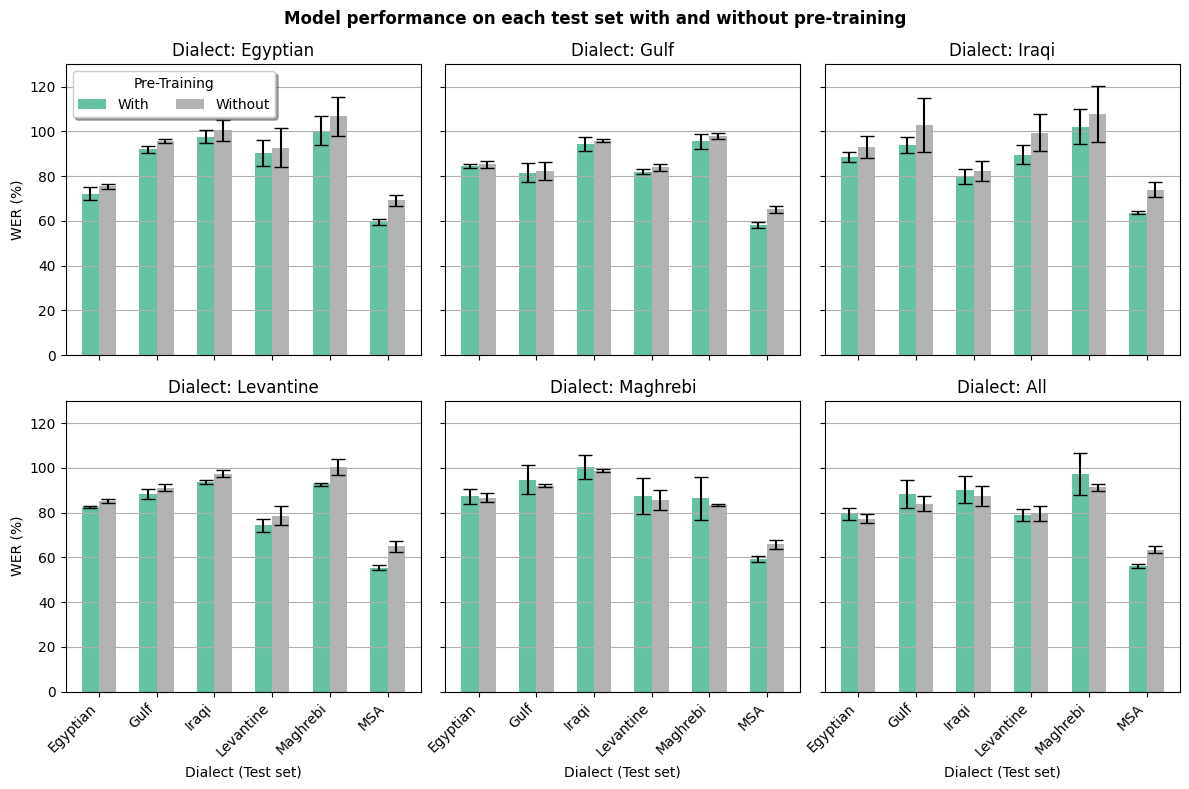

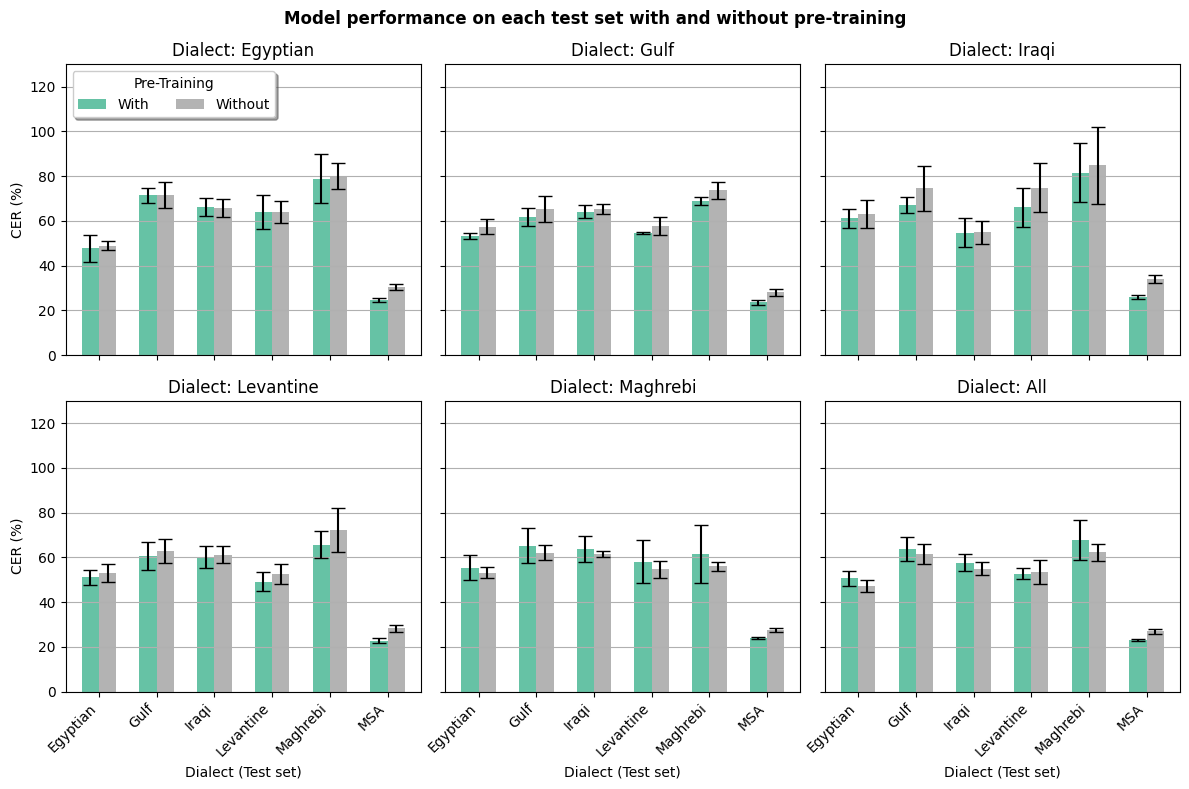

In [7]:
for res in ["WER", "CER"]:
    fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
    names = [c if c != "MSA" else "All" for c in df_full.columns]
    
    # Get consistent colors from Set2 colormap
    colors = plt.cm.Set2([0, 7])  # First two colors from Set2
    
    for i, name in enumerate(names):
        row = i // 3
        col = i % 3
        
        # Prepare data (keep original data processing)
        df_new = pd.concat([
            df_finetune.loc[res].loc[[name]], 
            df_scratch.loc[res].loc[[name]]
        ], keys=["With", "Without"], names=["Pre-Training"]).T

        # Extract numerical values
        df_new[['mean_with', 'std_with']] = df_new["With"][name].str.split(' ± ', expand=True).astype(float)
        df_new[['mean_without', 'std_without']] = df_new["Without"][name].str.split(' ± ', expand=True).astype(float)

        # Plot settings
        x = np.arange(len(df_new.index))  # x positions
        width = 0.3  # bar width

        # Plot bars with error - MATPLOTLIB bars instead of pandas plot
        bars_with = ax[row][col].bar(x - width/2, df_new['mean_with'], width,
                                    yerr=df_new['std_with'], capsize=5,
                                    color=colors[0], label='With')
        bars_without = ax[row][col].bar(x + width/2, df_new['mean_without'], width,
                                       yerr=df_new['std_without'], capsize=5,
                                       color=colors[1], label='Without')

        # Keep original formatting
        ax[row][col].set_title(f"Dialect: {name}")
        ax[row][col].grid(True, axis='y')
        ax[row][col].set_xticks(x)
        ax[row][col].set_xticklabels(df_new.index, rotation=45, ha='right')
        
        # Remove legends from individual plots
        ax[row][col].legend().remove()

    # Maintain original legend position and styling
    ax[0][0].legend(ncol=2, fancybox=True, shadow=True, 
                   title="Pre-Training", loc="upper left",
                   labels=["With", "Without"])
    
    # Keep original axis labels
    ax[0][0].set_ylabel(f"{res} (%)")
    ax[1][0].set_ylabel(f"{res} (%)")
    for i in range(3):
        ax[1][i].set_xlabel("Dialect (Test set)")
        ax[0][i].set_xticklabels([])

    # Maintain original layout constraints
    plt.ylim(bottom=0, top=130)

    fig.suptitle("Model performance on each test set with and without pre-training", 
                fontweight='bold')
    plt.subplots_adjust(
        wspace=0.0     # Reduced horizontal space between columns (was 0.3)
    )

    plt.tight_layout(w_pad=0.0)

    plt.savefig(f"results/plots/ex_comparison_{res.lower()}.pdf")
    plt.show()

## Statistical tests

In [8]:
from scipy import stats
from statsmodels.stats.multitest import multipletests

scratch_dist = load_results("results/ex_scratch", "dialect")
finetune_dist = load_results("results/ex_finetune", "finetune")

# drop the CER
scratch_dist = df_scratch.loc["WER"]
finetune_dist = df_finetune.loc["WER"]

# first split mean and std
scratch_mean = scratch_dist.map(lambda x: float(x.split(" ± ")[0]))
scratch_std = scratch_dist.map(lambda x: float(x.split(" ± ")[1]))
finetune_mean = finetune_dist.map(lambda x: float(x.split(" ± ")[0]))
finetune_std = finetune_dist.map(lambda x: float(x.split(" ± ")[1]))

# now remove the std
scratch_dist = scratch_mean
finetune_dist = finetune_mean

# calculate the mean and std of the difference
mean_scratch, std_scratch = scratch_dist.mean(), scratch_dist.std()
mean_finetune, std_finetune = finetune_dist.mean(), finetune_dist.std()

z_value, p_value = stats.wilcoxon(scratch_dist, finetune_dist)
test_df = pd.DataFrame({
    'Mean Without': mean_scratch,
    'Std Without': std_scratch,
    'Mean With': mean_finetune,
    'Std With': std_finetune,
    'Z-statistic': z_value,
    'p-value': p_value,
    'holm-bonferroni': multipletests(p_value, method='holm')[1],
}, index=mean_scratch.index)
test_df = test_df.round(2)
test_df['Mean Without'] = test_df['Mean Without'].astype(str) + ' ± ' + test_df['Std Without'].round(2).astype(str)
test_df['Mean With'] = test_df['Mean With'].astype(str) + ' ± ' + test_df['Std With'].round(2).astype(str)
test_df = test_df.drop(columns=['Std Without', 'Std With'])
test_df.rename(columns={'Mean Without': 'Without pre-training', 'Mean With': 'With pre-training'}, inplace=True)
test_df.to_latex("results/ttest.tex", bold_rows=True, caption="Wilcoxon results comparing the performance of models with and without pre-training", label="tab:ttest", float_format="%.2f")
test_df

,Without pre-training,With pre-training,Z-statistic,p-value,holm-bonferroni
Egyptian,83.82 ± 6.51,82.38 ± 5.95,4.0,0.22,0.88
Gulf,91.38 ± 7.56,89.81 ± 4.91,7.0,0.56,1.00
Iraqi,93.69 ± 7.22,92.74 ± 7.16,7.0,0.56,1.00
Levantine,86.63 ± 8.01,83.82 ± 6.43,2.0,0.09,0.47
Maghrebi,98.0 ± 9.33,95.76 ± 5.7,6.0,0.44,1.00
MSA,67.09 ± 3.82,58.71 ± 2.93,0.0,0.03,0.19


In [9]:
scratch_all_dist = scratch_dist.values.flatten()
finetune_all_dist = finetune_dist.values.flatten()
print(len(scratch_all_dist), len(finetune_all_dist))
z_value, p_value = stats.wilcoxon(scratch_all_dist, finetune_all_dist)
correction = 0.05 / len(scratch_all_dist)
print(f"Significance level: {correction}")

print(f"Z-value: {z_value:.2f}, p-value: {p_value}")
print(f"Mean without pre-training: {scratch_all_dist.mean():.2f}, Mean with pre-training: {finetune_all_dist.mean():.2f}")
print(f"Standard deviation without pre-training: {scratch_all_dist.std():.2f}, Standard deviation with pre-training: {finetune_all_dist.std():.2f}")
print(f"Degrees of freedom: {finetune_all_dist.size - 1}")

36 36
Significance level: 0.001388888888888889
Z-value: 120.00, p-value: 0.0005099171248730272
Mean without pre-training: 86.77, Mean with pre-training: 83.87
Standard deviation without pre-training: 11.94, Standard deviation with pre-training: 13.24
Degrees of freedom: 35


/var/folders/n5/h56c44710msgjz3ldp1zl6vw0000gn/T/ipykernel_41688/3111688493.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.arange(50, 111, 10), fontdict={"size": 16})


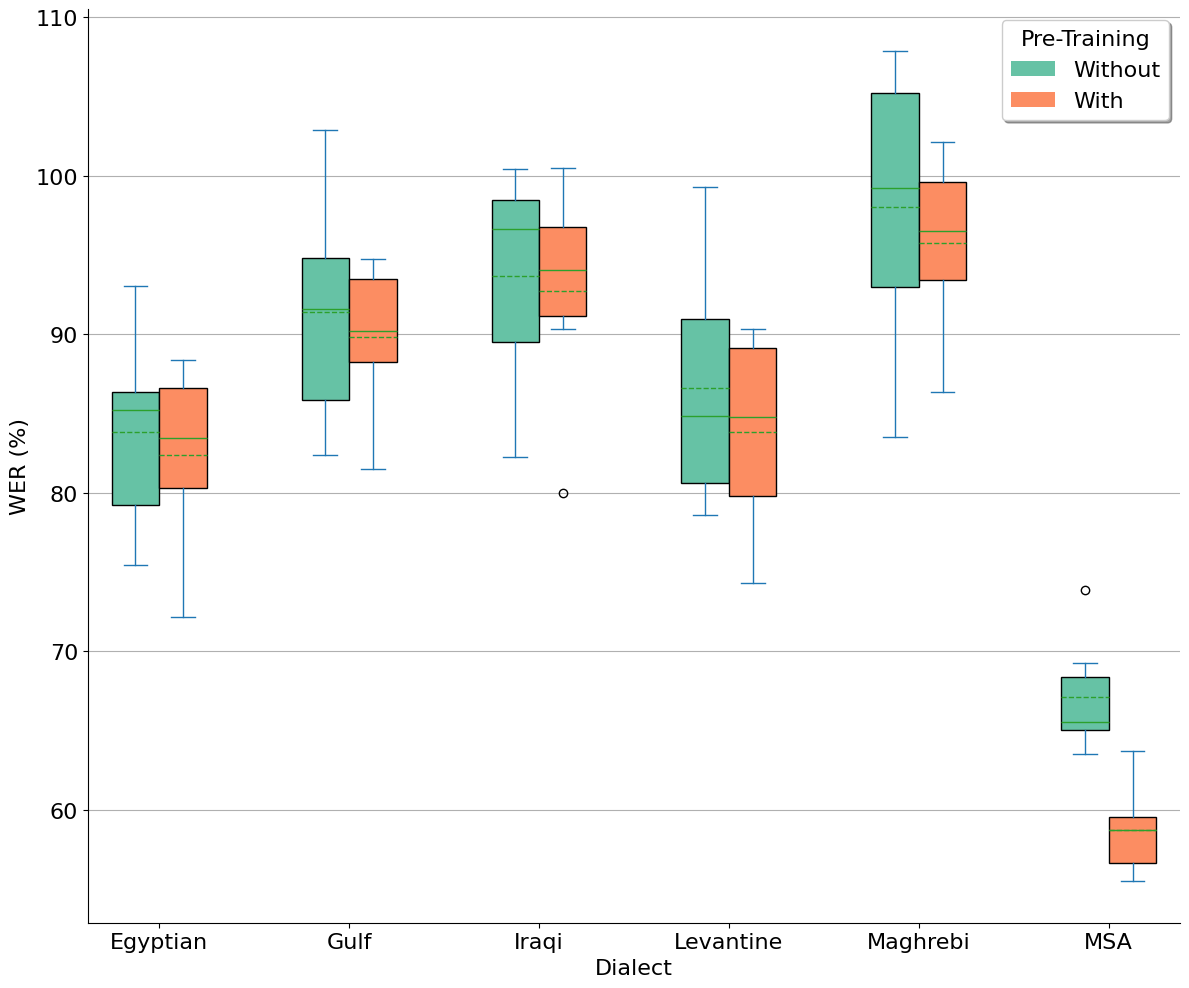

In [10]:
import matplotlib.patches as mpatches
import matplotlib

fig, ax = plt.subplots(figsize=(12, 10))
cmap = matplotlib.colormaps['Set2']
colors = [cmap(i) for i in range(2)]

scratch_dist.plot(kind='box', ax=ax, positions=np.arange(0, len(scratch_dist) *2, 2), showmeans=True, meanline=True, patch_artist=True, boxprops=dict(facecolor=colors[0]), label="Without")
finetune_dist.plot(kind='box', ax=ax, positions=[i-0.5 for i in np.arange(1, len(scratch_dist)*2, 2)], showmeans=True, meanline=True, patch_artist=True, boxprops=dict(facecolor=colors[1]), label="With")
ax.set_xticks(np.arange(0.25, len(scratch_dist)*2, 2))
ax.set_xticklabels(scratch_dist.T.index, fontdict={"size": 16})
ax.set_yticklabels(np.arange(50, 111, 10), fontdict={"size": 16})
ax.set_ylabel("WER (%)", fontdict={"size": 16})
ax.set_xlabel("Dialect", fontdict={"size": 16})
ax.legend(["Without", "With"], title="Pre-Training")
plt.tight_layout()
plt.grid(axis='y')
sns.despine()
plt.legend(loc='upper right',
            ncol=1, fancybox=True, shadow=True, title="Pre-Training", labels=["Without", "With"], handles=[mpatches.Patch(facecolor=colors[0], label="Without"), mpatches.Patch(facecolor=colors[1], label="With")], fontsize=16, title_fontsize=16)
plt.savefig("results/plots/ex_ttest_within.pdf")
plt.show()

# Experiment 3: Dialectal Arabic Fine-Tuning

In [11]:
df_finetune = load_results("results/ex_finetune", "finetune")
df_scratch = load_results("results/ex_scratch", "dialect")

# first split mean and std
scratch_mean = df_scratch.map(lambda x: float(x.split(" ± ")[0]))
scratch_std = df_scratch.map(lambda x: float(x.split(" ± ")[1]))
finetune_mean = df_finetune.map(lambda x: float(x.split(" ± ")[0]))
finetune_std = df_finetune.map(lambda x: float(x.split(" ± ")[1]))

In [12]:
for dialect in ["Egyptian", "Levantine", "Gulf", "Iraqi", "Maghrebi"]:
    new_df = finetune_mean.loc["WER"].drop(columns=["MSA", dialect]).loc[dialect]
    print(dialect, new_df.mean().round(2))

Egyptian 95.1
Levantine 89.26
Gulf 89.13
Iraqi 93.54
Maghrebi 92.5


In [13]:
def plot_cm(df, metric, pretraining):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    # cm_df = df.drop("All", level="model")
    cm_df = df
    cm_df = cm_df.drop("Whisper", level="model")
    cm_df = cm_df.drop(columns=["MSA"])
    cm_df.columns = list(cm_df.loc["WER"].index)

    sns.heatmap(cm_df.loc[metric], annot=True, cmap='viridis_r', fmt='g', cbar=True, ax=ax)
    plt.title(f"Model performance in {metric} (%) against each dialect {pretraining} pre-training")
    plt.ylabel("Dialect fine-tuned on")
    plt.xlabel("Dialect tested on")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"results/plots/ex_{'finetune' if pretraining == 'with' else 'scratch'}_cm_{metric.lower()}.pdf")
    plt.show()


In [14]:
def plot_cm(df_mean, df_std, metric, pretraining):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Process mean DataFrame
    cm_mean = df_mean.drop("All", level="model")
    # cm_mean = cm_mean.drop("Whisper", level="model")
    cm_mean = cm_mean.drop(columns=["MSA"])
    cm_mean.columns = list(cm_mean.loc["WER"].index)  # Assuming WER exists in index
    
    # Process std DataFrame
    cm_std = df_std.drop("All", level="model")
    # cm_std = cm_std.drop("Whisper", level="model")
    cm_std = cm_std.drop(columns=["MSA"])
    cm_std.columns = list(cm_std.loc["WER"].index)  # Same column processing
    
    # Create combined annotations with rounding
    annot_df = (cm_mean.loc[metric].round(2).astype(str) + 
               "\n (± " + 
               cm_std.loc[metric].round(2).astype(str)) + ")"
    
    # Plot heatmap using mean values with combined annotations
    sns.heatmap(cm_mean.loc[metric], 
                annot=annot_df, 
                cmap='viridis_r', 
                fmt='',  # Disable automatic formatting
                cbar=True, 
                ax=ax)
    
    plt.title(f"Model performance in {metric} (%) against each dialect {pretraining} pre-training")
    plt.ylabel("Dialect fine-tuned on")
    plt.xlabel("Dialect tested on")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"results/plots/ex_{'finetune' if pretraining == 'with' else 'scratch'}_cm_{metric.lower()}.pdf")
    plt.show()

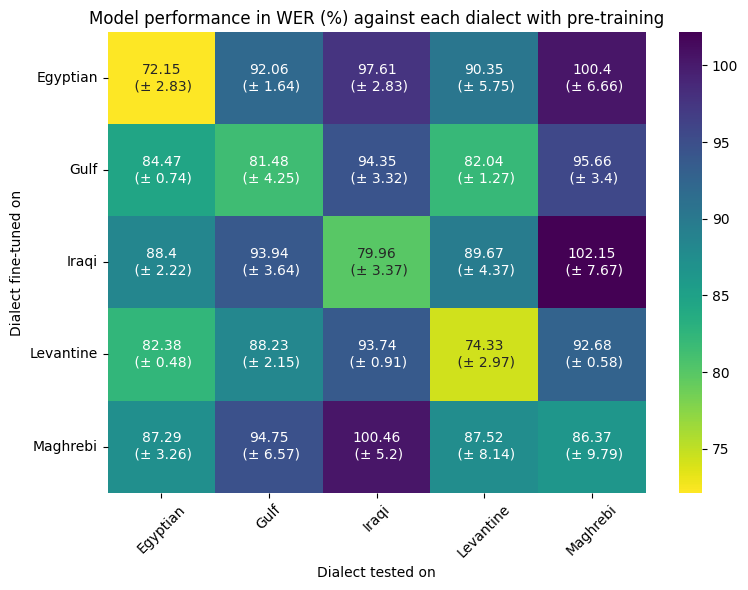

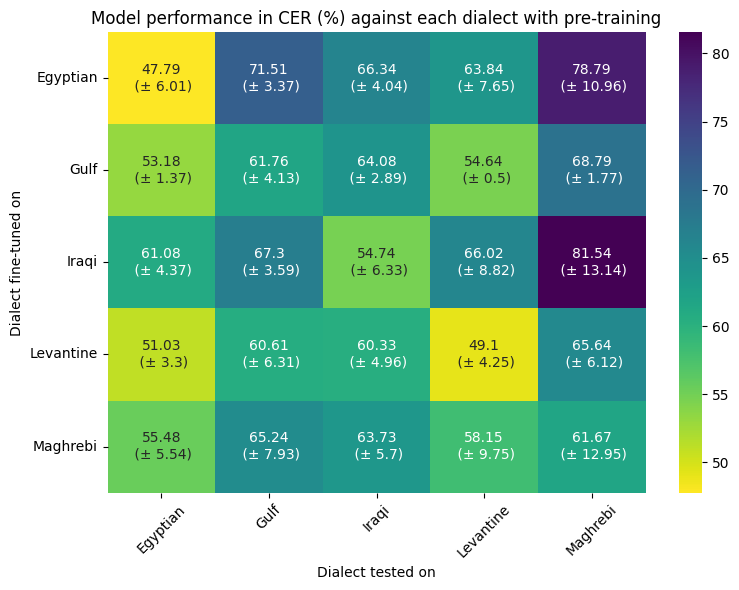

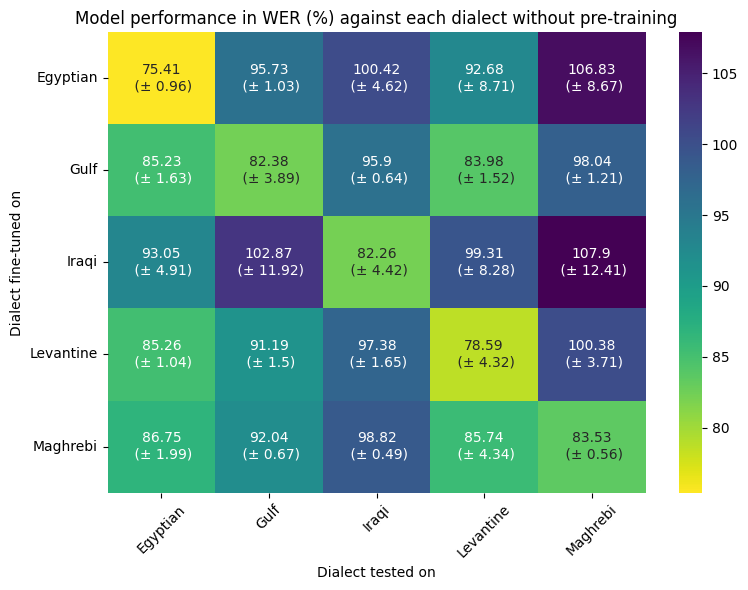

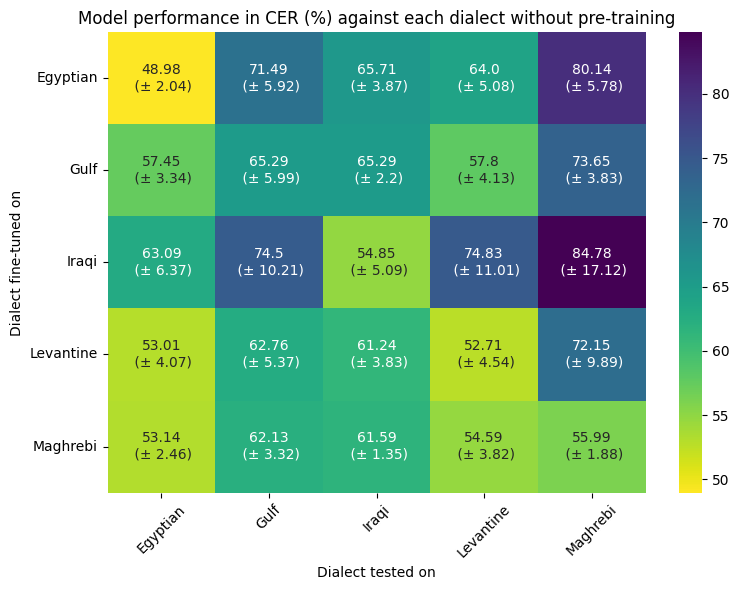

In [15]:
plot_cm(finetune_mean, finetune_std, "WER", "with")
plot_cm(finetune_mean, finetune_std, "CER", "with")
plot_cm(scratch_mean, scratch_std, "WER", "without")
plot_cm(scratch_mean, scratch_std, "CER", "without")

In [16]:
def plot_results(df, title, filename):
    fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True, sharey=False)
    for i, res in enumerate(["WER", "CER"]):
        axes = df.loc[res].plot(kind='bar', ax=ax[i], colormap='Set2', rot=0)
        ax[i].set_ylabel(f"{res} (%)")
        ax[i].set_ylim(0, 120 + 40 * (i == 0))
        ax[i].set_yticks(np.arange(0, 120 + 40 * (i == 0), 20))
        ax[i].grid(axis='y')
        for g in axes.containers:
            g_label = g.get_label()
            for i, child in enumerate(g.get_children()):
                bar_name = df.loc[res].iloc[i].name
                if bar_name == g_label:
                    child.set(hatch='//')
    sns.despine()
    ax[1].set_xlabel("Dialect(s) trained on")
    ax[0].legend(loc='upper right', bbox_to_anchor=(1.1, 1.02), ncol=1, fancybox=True, shadow=True, title="Test set")
    ax[1].legend().remove()
    fig.suptitle(title, fontweight='bold')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

In [17]:
def plot_results(df_mean, df_std, title, filename):
    fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True, sharey=False)
    
    for i, res in enumerate(["WER", "CER"]):
        # Plot bars with error bars using pandas' built-in error bars
        axes = df_mean.loc[res].plot(kind='bar', ax=ax[i], colormap='Set2', rot=0,
                                    yerr=df_std.loc[res], error_kw={'elinewidth': 1, 'capthick': 1}, capsize=2)
        
        ax[i].set_ylabel(f"{res} (%)")
        ax[i].set_ylim(0, 120 + 40 * (i == 0))
        ax[i].set_yticks(np.arange(0, 120 + 40 * (i == 0), 20))
        ax[i].grid(axis='y')
        
        # Add hatches to bars
        for g in axes.containers:
            # Skip error bar containers (last container)
            # if not isinstance(g, plt.ErrorbarContainer):
            g_label = g.get_label()
            for j, child in enumerate(g.get_children()):
                bar_name = df_mean.loc[res].iloc[j].name
                if bar_name == g_label:
                    child.set(hatch='//')

    ax[1].set_xlabel("Dialect(s) trained on")
    ax[0].legend(loc='upper right', bbox_to_anchor=(1.1, 1.02), ncol=1, 
                fancybox=True, shadow=True, title="Test set")
    ax[1].legend().remove()
    fig.suptitle(title, fontweight='bold')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

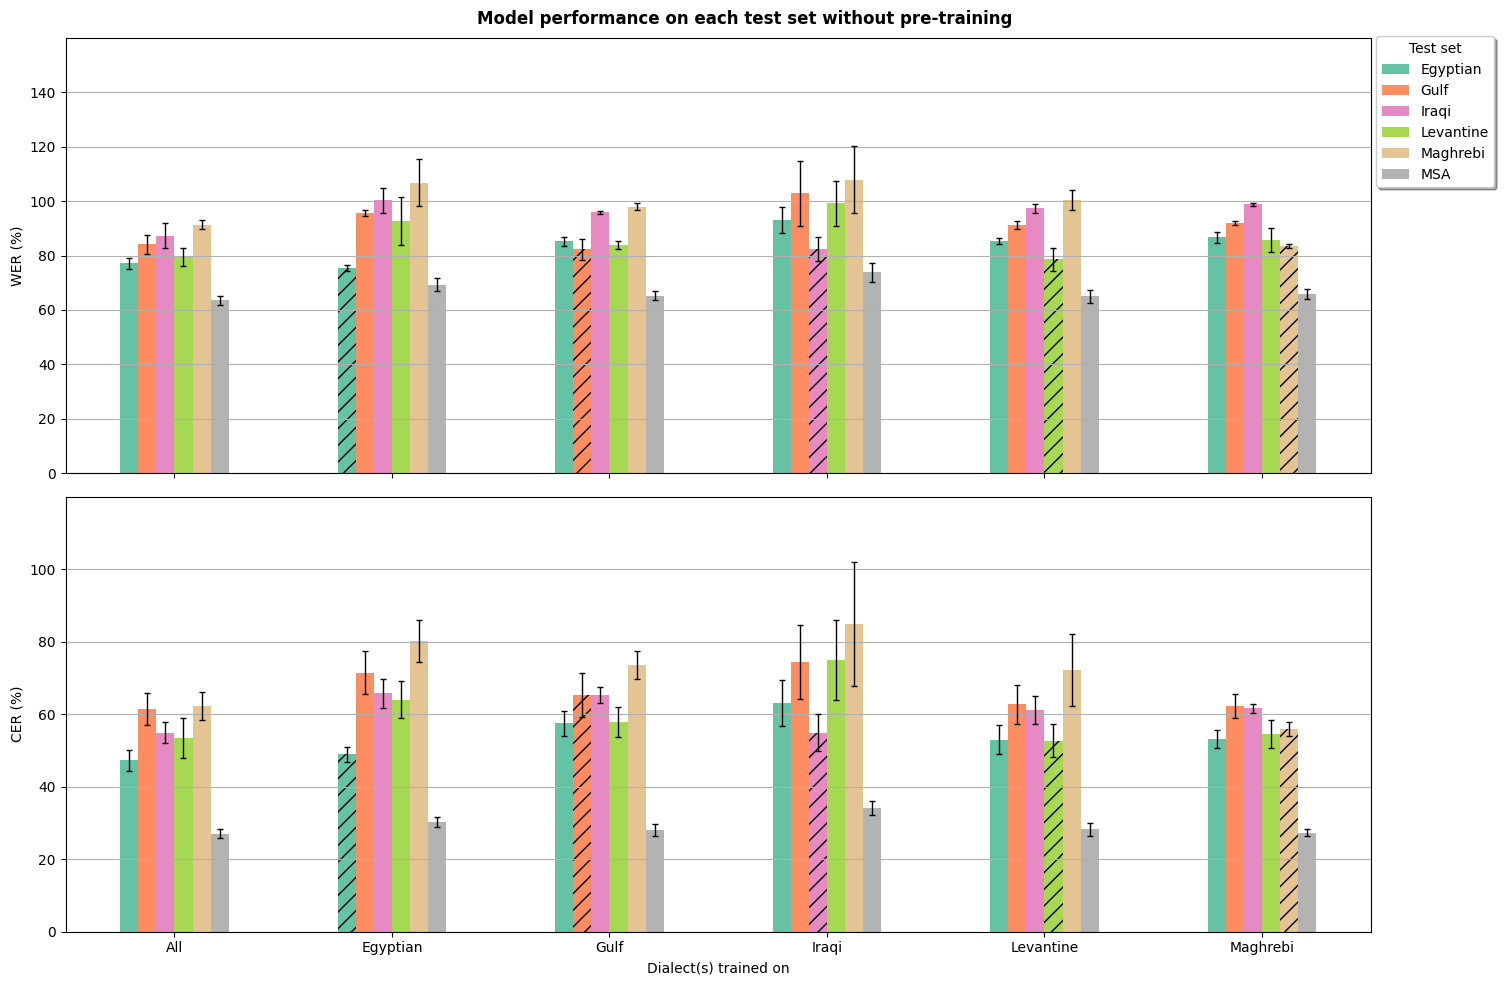

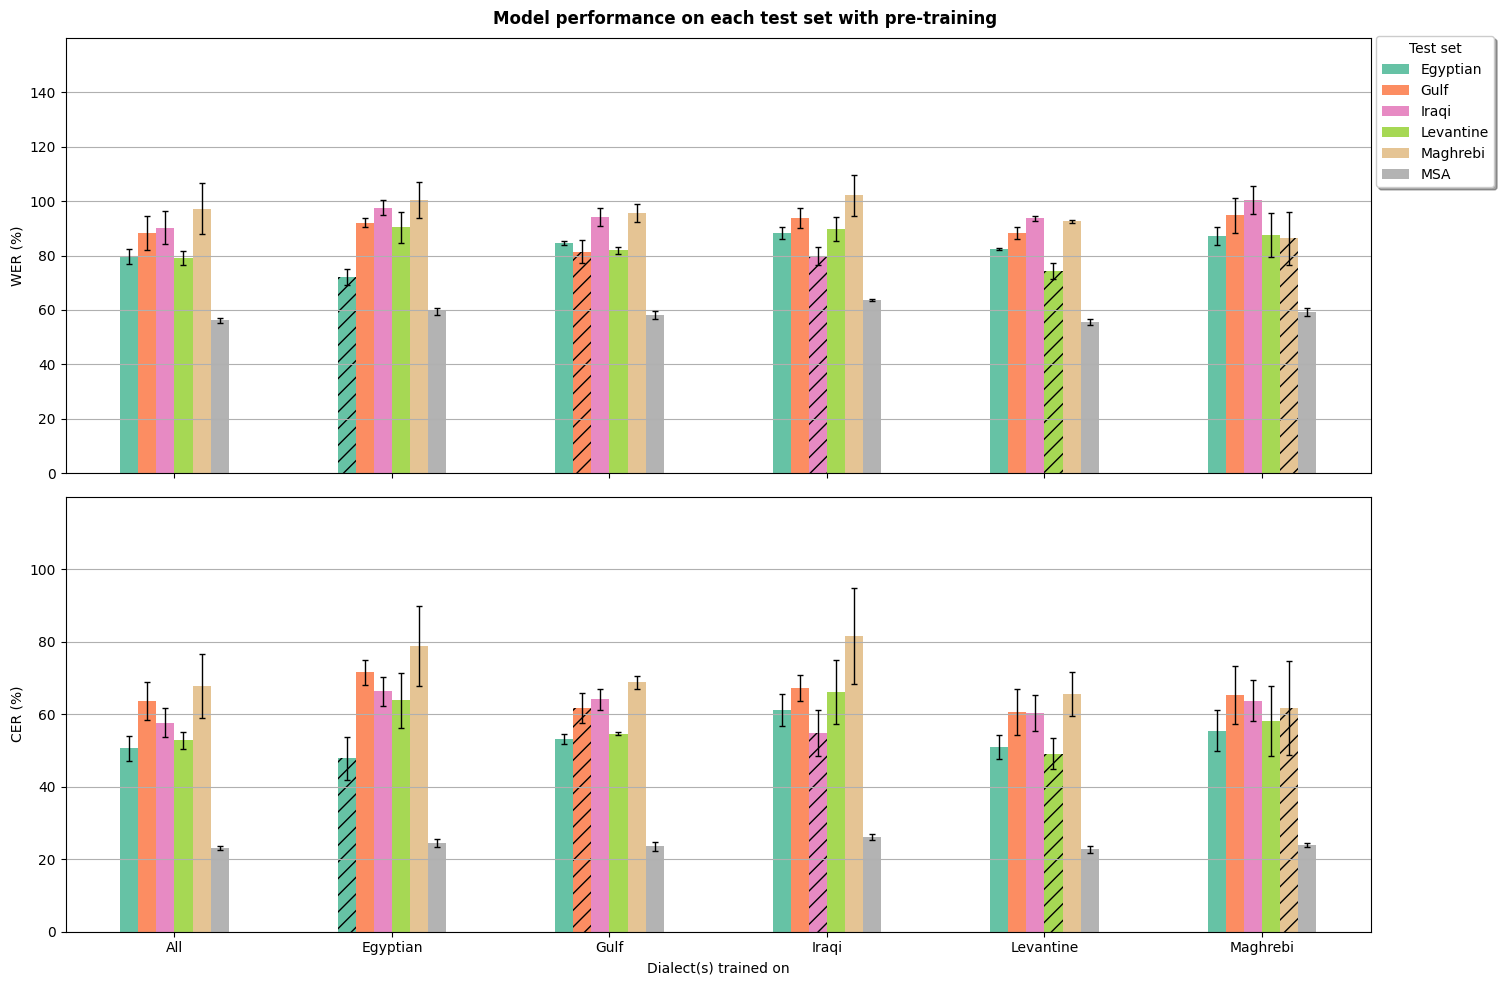

In [18]:
plot_results(scratch_mean, scratch_std, "Model performance on each test set without pre-training", "results/plots/ex_scratch.pdf")
plot_results(finetune_mean, finetune_std, "Model performance on each test set with pre-training", "results/plots/ex_finetune.pdf")

Mean absolute error between dialect-pooled and dialect-specific models for WER: 8.42
Mean absolute error between dialect-pooled and dialect-specific models for CER: 3.37


/var/folders/n5/h56c44710msgjz3ldp1zl6vw0000gn/T/ipykernel_41688/3451520139.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(np.arange(0, 111, 20), fontdict={"size": 16})


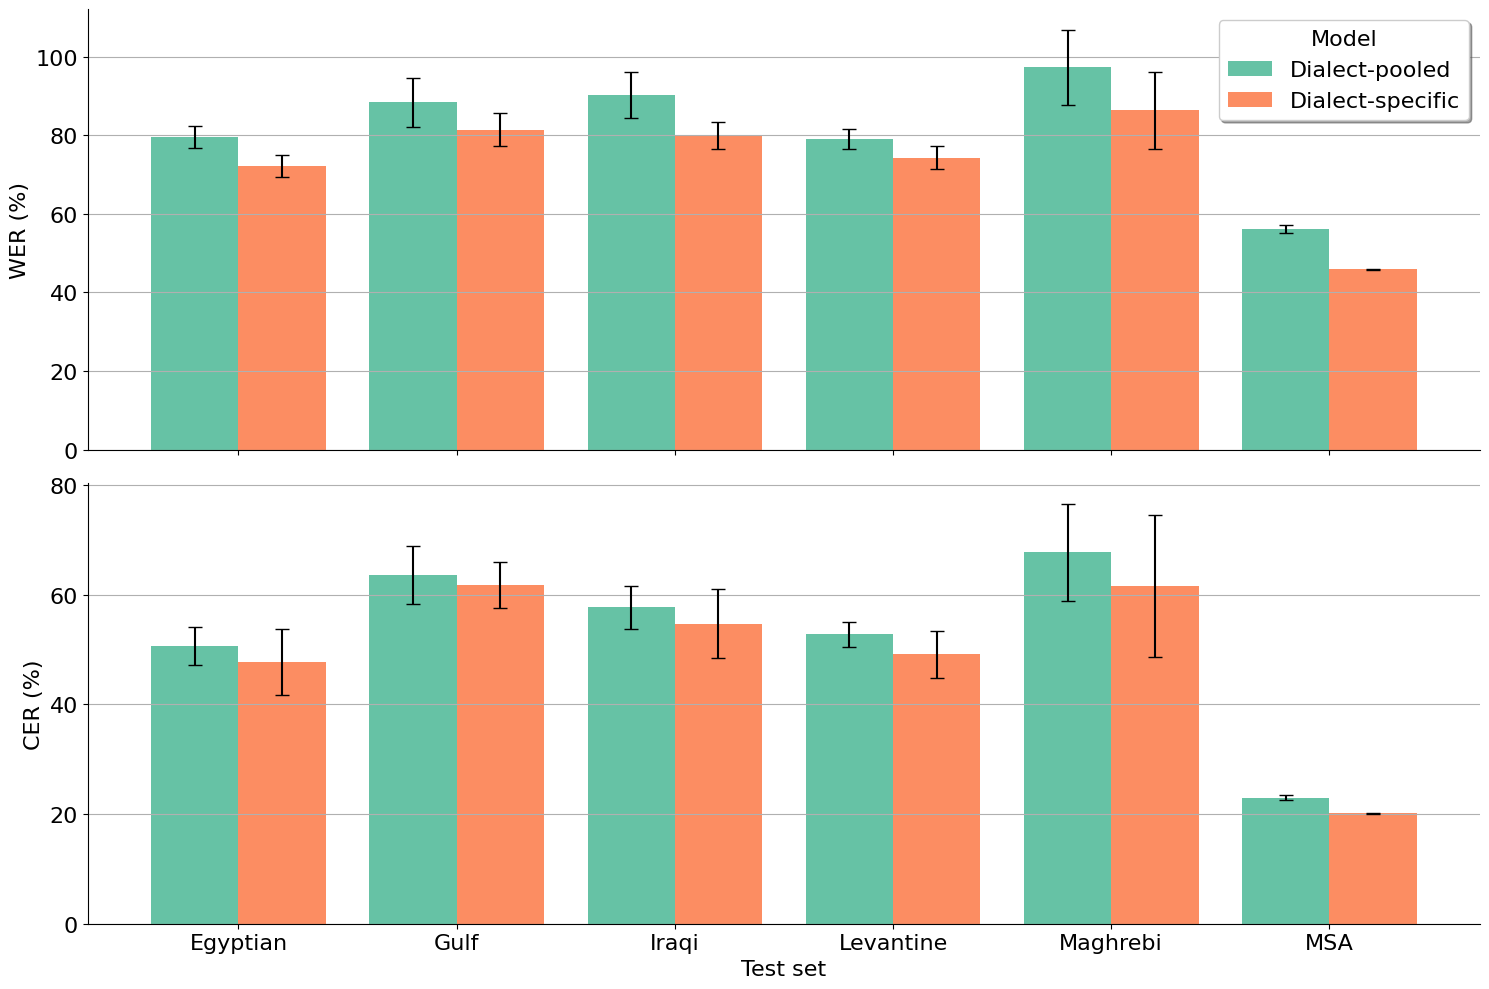

In [19]:
import matplotlib

fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True, sharey=False)
cmap = matplotlib.colormaps['Set2']
colors = [cmap(i) for i in range(2)]
dfs = []

width = 0.4
for i, res in enumerate(["WER", "CER"]):
    multiplier = 0
    all_res = dict(df_finetune.loc[res].loc["All"].items())
    x = np.arange(len(all_res.keys()))
    y1 = [all_res[k] for k in all_res.keys()]
    y2 = [df_finetune.loc[res].loc[k][k] for k in all_res.keys() if k != "MSA"] + [df_trainsize.loc["100%"].loc[res]]
    std_y1 = [float(v.split(" ± ")[1]) if isinstance(v, str) else 0 for v in y1]
    std_y2 = [float(v.split(" ± ")[1]) if isinstance(v, str) else 0 for v in y2]

    y1 = [float(v.split(" ± ")[0]) if isinstance(v, str) else v for v in y1]
    y2 = [float(v.split(" ± ")[0]) if isinstance(v, str) else v for v in y2]
    df_diff = pd.DataFrame({"Dialect-pooled": y1, "Dialect-specific": y2}, index=all_res.keys()).round(2)
    mae = np.mean(np.abs(np.array(y1) - np.array(y2)))
    print(f"Mean absolute error between dialect-pooled and dialect-specific models for {res}: {mae:.2f}")

    ax[i].bar(x-0.2 + multiplier, y1, width, label=f"Dialect-pooled", color=colors[0])
    ax[i].bar(x+0.2 + multiplier, y2, width, label=f"Dialect-specific", color=colors[1])
    ax[i].errorbar(x-0.2 + multiplier, y1, yerr=std_y1, fmt='none', ecolor='black', capsize=5)
    ax[i].errorbar(x+0.2 + multiplier, y2, yerr=std_y2, fmt='none', ecolor='black', capsize=5)
    ax[i].grid(axis='y')
    ax[i].set_ylim(bottom=0)
    ax[i].set_ylabel(f"{res} (%)", fontdict={"size": 16})
    multiplier += 0.4
    dfs.append(df_diff)
sns.despine()
ax[0].set_yticklabels(np.arange(0, 111, 20), fontdict={"size": 16})
ax[1].set_yticks(np.arange(0, 81, 20))
ax[1].set_yticklabels(np.arange(0, 81, 20), fontdict={"size": 16})
ax[1].set_xlabel("Test set", fontdict={"size": 16})
# concatenate the dataframes with a multi index and save them to a latex file
df_diff = pd.concat(dfs, keys=["WER", "CER"], names=["Metric"])
df_diff.to_latex(f"results/ex_comparison_dialectal.tex", multirow=True, multicolumn=True, multicolumn_format="c", bold_rows=True, caption=f"Model performance comparison dialect-pooled vs dialect-specific for {res}", label=f"tab:ex_comparison_dialectal", float_format="%.2f")
plt.xticks(x, [k for k in all_res.keys()], fontdict={"size": 16})
plt.xlabel("Test set")
ax[0].legend(title="Model", loc='upper right', ncol=1, fancybox=True, shadow=True, fontsize=16, title_fontsize=16)
plt.tight_layout()
plt.savefig("results/plots/ex_comparison_pooled.pdf")
plt.show()